# Classifiez automatiquement des biens de consommation

- **Projet 6 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 2 : Classification des images


<!--TABLE OF CONTENTS-->

Contents:

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
- [2. Import, nettoyage et analyse exploratoire des données](#2.-Import,-nettoyage-et-analyse-exploratoire-des-données)
  - [2.1 Import des données textes pour récuperer les images](#2.1-Import-des-données-textes-pour-récuperer-les-images)
  - [2.1 Import des images (lecture)](<#2.1-Import-des-images-(lecture)>)
  - [2.2 Nettoyage des données](#2.2-Nettoyage-des-données)
  - [3.1 Préparation des catégories](#3.1-Préparation-des-catégories)
  - [Enregistre les données préparées](#Enregistre-les-données-préparées)
  - [Nettoyage des variables globales](#Nettoyage-des-variables-globales)
- [4. Fonctions communs pour modèles classification](#4.-Fonctions-communs-pour-modèles-classification)
  - [4.1 Lecture des données](#4.1-Lecture-des-données)
  - [4.2 Modélisation et évaluation des modèles:](#4.2-Modélisation-et-évaluation-des-modèles:)
  - [4.3 Visualisations de metriques de performance](#4.3-Visualisations-de-metriques-de-performance)
  - [4.4 Visualisation des clusters sur les 'reduced_dimensions'](#4.4-Visualisation-des-clusters-sur-les-'reduced_dimensions')
- [9. Enregistrement des résultats](#9.-Enregistrement-des-résultats)


# 1. Compréhension du problème

## 1.1 Mission

Etudier la faisabilité d'un **moteur de classification** des articles en différentes catégories,
avec un niveau de précision suffisant.

- **réaliser une première étude de faisabilité d'un moteur de classification**, d'articles, basé sur
  une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- **analyser le jeu de données** en **réalisant un prétraitement** des descriptions des produits et
  des images, une **réduction de dimension**, puis un **clustering**, à présenter sous la forme de
  graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories
  réelles et les clusters.
- illustre que les caractéristiques extraites permettent de regrouper des produits de même
  catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des
  produits de même catégorie


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [102]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [103]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas',
                      'matplotlib', 'seaborn', 'scikit-learn',
                      'pillow'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import PIL


### 1.2.2 Liste des versions des bibliothèques utilisées


In [105]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; sklearn==1.0.2; PIL==8.4.0; PIL.Image==8.4.0


### 1.2.3 Configuration défauts d'affichage


In [106]:
from sklearn import set_config

pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context


### 1.2.4 Quelques constants


In [107]:
# Definir RANDOM_SEED = None pour des résultats variables
# Ici on définit RANDOM_SEED = constant seulement pour réproducibilité
RANDOM_SEED = 42


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [108]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/analyse'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [109]:
def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [110]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """
    Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import, nettoyage et analyse exploratoire des données

Un premier jeu de données d’articles avec la photo et une description associée :
[le lien pour télécharger](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)

Un fois téléchargé, les données du fichier zip (329 Mo) sont éxtraites dans le dossier définit par DATA_FOLDER ci-dessous.


In [111]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = 'data/raw'
    OUT_FOLDER = 'data/out'
    IMAGE_FOLDER = 'images/textes'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC6'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC6'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC6/nettoyage'


In [112]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Dataset+projet+prétraitement+textes+images.zip'
RAW_DATA_FILENAME = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'


def os_make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def os_path_join(folder, file):
    """remplacement pour `os.path.join(folder, file)` sur windows"""
    return f'{folder}/{file}'


os_make_dir(IMAGE_FOLDER)
RAW_DATA = os_path_join(DATA_FOLDER, RAW_DATA_FILENAME)
DATA_ZIPPED = os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv


In [113]:
def unzip_data_si_besoin(env=ENV):
    """
    procedure pour unzip sur Google Drive via Google Colab
    """
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv)


## 2.1 Import des données textes pour récuperer les images

Les données textes sont traités dans Partie 1.

On récrée les colonnes de catégories, puis supprime les colonnes pas utiles pour classification


In [114]:
df_data = pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
print(list(df_data.columns))


['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']


### 2.1.1 Préparation des catégories

Features à créer à partir du `product_category_tree` :

- `categ_level_1` : les catégories à la racine de l'arbre
- `categ_level_2` : les sous-catégories (divisions dans `categ_level_1`)
- `categ_level_3` : les mini-catégories (divisions dans `categ_level_2`)


In [115]:
def create_categ_level(df, max_depth=3):
    if not 'product_category_tree' in df.columns:
        return df
    else:
        df_cat = (df_data['product_category_tree']
                  .str.lstrip('["').str.rstrip('"]').str.split(' >>', expand=True))
        df_cat = df_cat[df_cat.columns[range(max_depth)]]
        df_cat.columns = [f'categ_level_{i}' for i in range(1, max_depth+1)]
        return pd.concat([df, df_cat], axis=1)


df_data.pipe(create_categ_level).iloc[:, -3:].head()


,categ_level_1,categ_level_2,categ_level_3
0,Home Furnishing,Curtains & Accessories,Curtains
1,Baby Care,Baby Bath & Skin,Baby Bath Towels
2,Baby Care,Baby Bath & Skin,Baby Bath Towels
3,Home Furnishing,Bed Linen,Bedsheets
4,Home Furnishing,Bed Linen,Bedsheets


### 2.1.2 Elimination des colonnes non-pertinentes au problématique

Avant de faire du feature engineering, on supprime les colonnes non-utilisées pour classification


In [116]:
def drop_unused_columns(df):
    """supprimer les colonnes qui ne sont pas pertinentes"""
    colonnes_non_pertinentes = ['uniq_id', 'crawl_timestamp', 'product_url', 'product_category_tree',
                                'retail_price', 'discounted_price',
                                'is_FK_Advantage_product', 'product_rating', 'overall_rating', 'product_specifications']
    cols_to_drop = cols_in_df(df, colonnes_non_pertinentes)
    print(f'dropping {len(cols_to_drop)} unused columns')
    return df.drop(columns=cols_to_drop)


df_data = (
    pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
    .pipe(create_categ_level)
    .pipe(drop_unused_columns)
)
print(list(df_data.columns))
print(df_data.shape)


dropping 10 unused columns
['product_name', 'pid', 'image', 'description', 'brand', 'categ_level_1', 'categ_level_2', 'categ_level_3']
(1050, 8)


In [117]:
df_data.head(2)


,product_name,pid,image,description,brand,categ_level_1,categ_level_2,categ_level_3
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",Elegance,Home Furnishing,Curtains & Accessories,Curtains
1,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,7b72c92c2f6c40268628ec5f14c6d590.jpg,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels


## 2.1 Import des images (lecture)

Les images sont decompressés du fichier zip dans le sous-dossier `DATA_FOLDER/Flipkart/Images'


In [118]:
import os
IMG_FOLDER = f'{DATA_FOLDER}/Flipkart/Images'

os.listdir(IMG_FOLDER)[:5]


['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg']

### Lecture d'un image


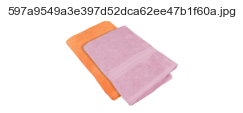

In [119]:
from PIL import Image
import os


def preview_image(filename=None, img=None, ax=None, titre=None,
                  preprocess_fct=None,
                  preprocess_params={}):
    if img is None:
        if filename is None:
            # seed = np.random.randint(0, 1050)
            seed = 352
            filename = os.listdir(IMG_FOLDER)[seed]

        # Charger l'image
        img = Image.open(f'{IMG_FOLDER}/{filename}')

    if not preprocess_fct is None:
        img = preprocess_fct(img, preprocess_params)

    # Afficher l'image chargée dans jupyter
    if ax is None:
        fig = plt.figure(figsize=(2, 2))
        ax = plt.gca()
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()

    if titre is None:
        titre = filename
    ax.set_title(titre)


preview_image()


### Visualisations des catégories


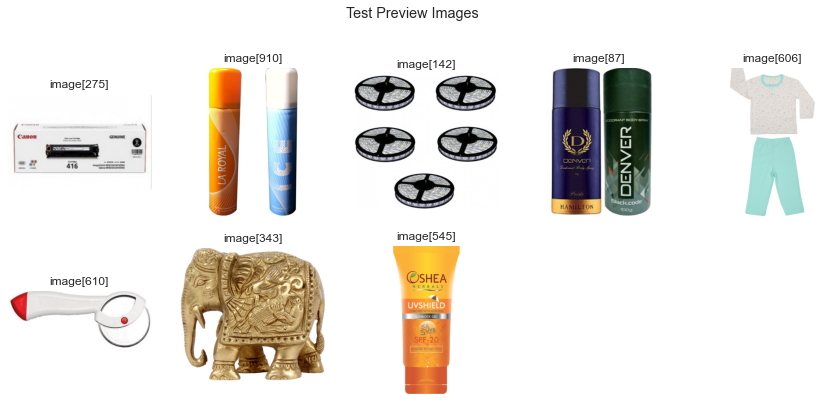

In [120]:
def preview_images(filenames, titles, titre,
                   preprocess_fct=None,
                   preprocess_params={}):
    n_cols = 5
    n_rows = len(filenames) // n_cols + (len(filenames) % n_cols > 0)
    fig = plt.figure(figsize=(n_cols*3, n_rows*3))
    for n, filename in enumerate(filenames):
        image_title = None
        if len(titles) > n:
            image_title = ' '.join(str(titles[n]).split(' ')[-2:])
        ax = plt.subplot(n_rows, n_cols, n + 1)
        preview_image(filename, titre=image_title, ax=ax,
                      preprocess_fct=preprocess_fct, preprocess_params=preprocess_params)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.suptitle(titre, y=1.02)


# seeds= np.random.randint(0, 1050,8)
seeds = [275, 910, 142, 87, 606, 610, 343, 545]
filenames = [os.listdir(IMG_FOLDER)[seed] for seed in seeds]
titles = [f'image[{seed}]' for seed in seeds]
preview_images(filenames, titles, titre='Test Preview Images')


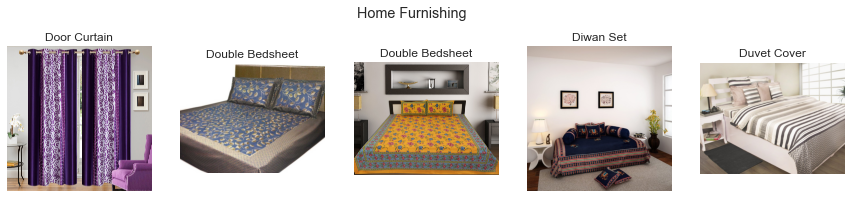

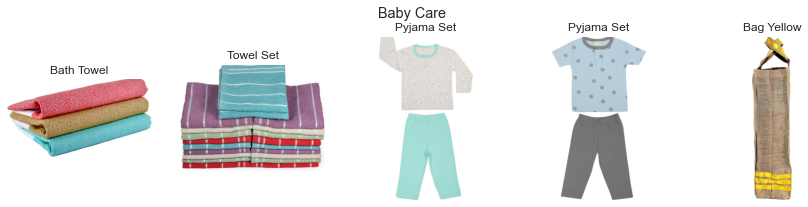

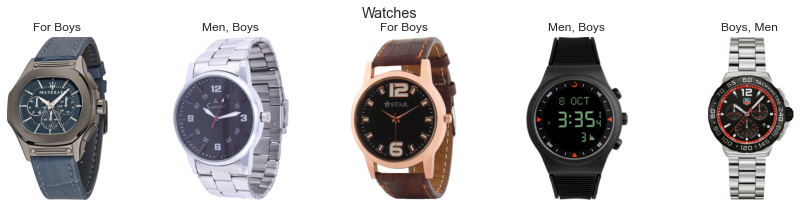

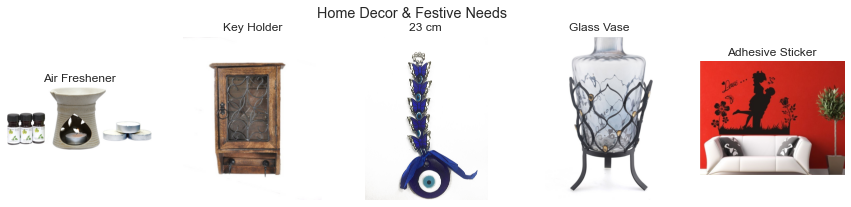

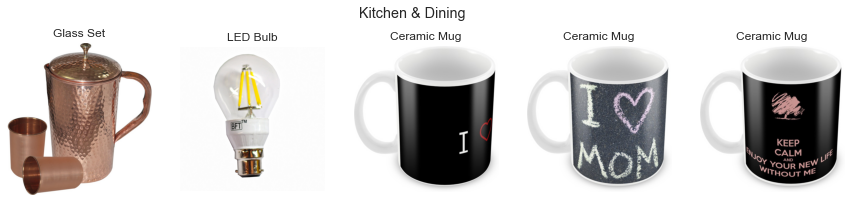

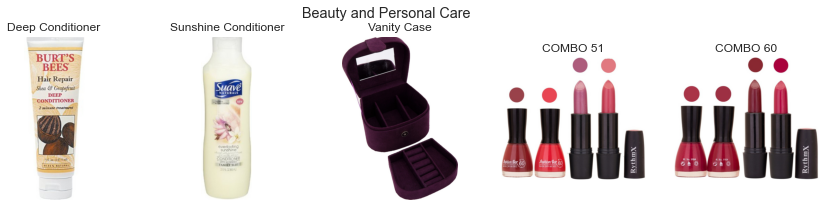

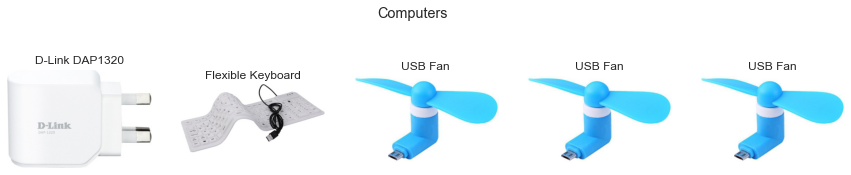

In [121]:

def preview_images_by_category(df, categ_col='categ_level_1',
                               feature='image', nb=5,
                               preprocess_fct=None,
                               preprocess_params={}
                               ):
    """echantillon d'images par catégorie"""
    categories = df[categ_col].unique()
    for n, category in enumerate(categories):
        filenames = df[df[categ_col] == category][feature]
        product_names = df[df[categ_col] == category]['product_name']
        nb_im = min(nb, len(filenames))
        filenames = list(filenames[:nb_im])
        product_names = list(product_names[:nb_im])
        preview_images(filenames, titles=product_names, titre=category,
                       preprocess_fct=preprocess_fct, preprocess_params=preprocess_params)


preview_images_by_category(df_data)


In [122]:
df_data.duplicated(subset=['image']).sum()


0

Il y a un image unique pour chaque produit, même si les images peuvent être identiques


## 2.2 Nettoyage des données

Les images peuvent avoir besoin de prétraitement, qui dépend du modèle de machine learning

- conversion de FileFormat
- Egalisation d'exposition (`PIL.ImageOps.autocontrast`)
- Egalisation de contrast (`PIL.ImageOps.equalize` )
- Filtrage de bruit (`PIL.Image.filter.GaussianBlur`)
- Filtrage de bruit (`PIL.Image.filter.MedianFilter`)
- conversion en gris (réduction de dimensions de couleur)
- reduction de taille (square, remplit)

On crée des procédures ci-dessous


### Image témoin

- images pour tester les procédures de prétraitement

> Seeds: [854 ,203, 902, 756 ]


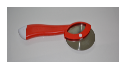

In [123]:

def get_image(seed=None):
    """Fonction pour recupérer un image temoin à tester"""
    if seed is None:
        nb_files = len(os.listdir(IMG_FOLDER))
        seed = np.random.randint(0, nb_files)
        print(f'get_image {seed}')
    filename = os.listdir(IMG_FOLDER)[seed]
    # Charger l'image
    return Image.open(f'{IMG_FOLDER}/{filename}')


IMG = get_image(854)
# IMG = get_image()
preview_image(img=IMG)


### Visualisation d'un image et son histogram


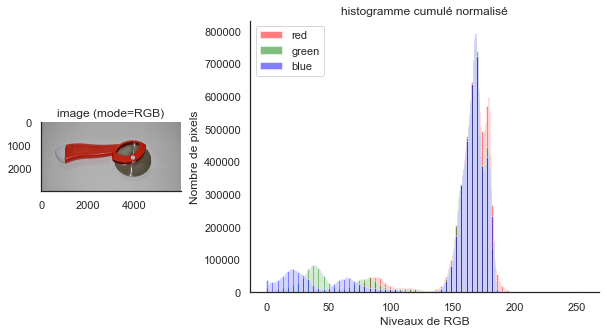

In [124]:
def plot_image_histogram(img, cumul_=False):
    if type(img) == np.ndarray:
        img_ = img
        img = Image.fromarray(img)
    else:
        img_ = np.array(img)
        img = img
    fig = plt.figure(figsize=(10, 5), constrained_layout=False)
    gs = fig.add_gridspec(1, 3)
    ax = plt.subplot(gs[:, 0])
    plt.imshow(img_, cmap='gray')
    ax.set_title(f'image (mode={img.mode})')

    # Générer et afficher l'histogramme
    # Pour le normaliser : argument density=True dans plt.hist
    # Pour avoir l'histogramme cumulé : argument cumulative=True
    ax = plt.subplot(gs[:, 1:])
    if len(img_.shape) == 3:
        for i, colour in enumerate(['red', 'green', 'blue']):
            plt.hist(img_[:, :, i].flatten(), bins=range(256), cumulative=cumul_,
                     color=colour, alpha=0.5, label=colour)
        plt.legend(loc='upper left')
    else:
        # n, bins, patches =
        plt.hist(img_.flatten(), bins=range(256),
                 cumulative=cumul_, label='grey')
        plt.legend(loc='upper left')

    xlabel = 'RGB' if img.mode == 'RGB' else 'gris'
    ax.set_xlabel(f'Niveaux de {xlabel}')

    if cumul_:
        ax.set_ylabel('Nombre de pixels cumulé')
    else:
        ax.set_ylabel('Nombre de pixels')

    ax.set_title('histogramme cumulé normalisé')
    sns.despine()
    plt.subplots_adjust(wspace=0.5)


plot_image_histogram(IMG)


### Egalisation d'exposition

Utilisant (`PIL.ImageOps.autocontrast`)


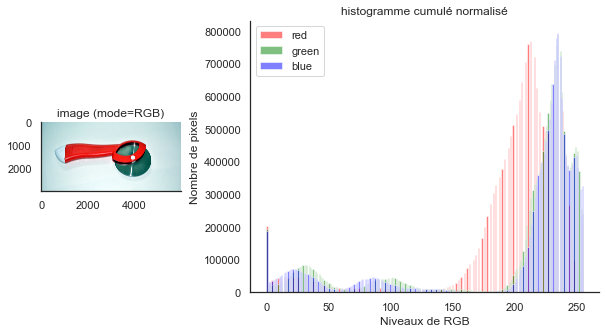

In [125]:
from PIL.ImageOps import autocontrast
from PIL import Image


def img_contrast(img, cutoff=1):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    img_etire = autocontrast(img, cutoff=cutoff)
    return img_etire


plot_image_histogram(img_contrast(IMG))


### Egalisation de contrast

(`PIL.ImageOps.equalize` )


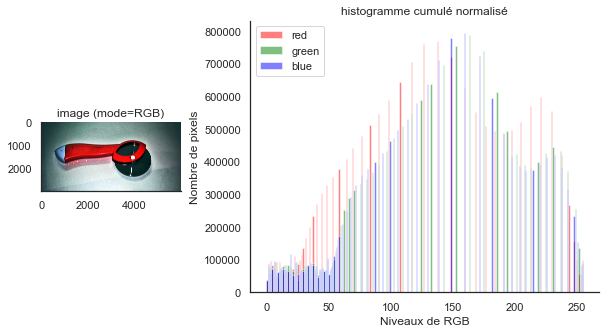

In [126]:
from PIL.ImageOps import equalize
from PIL import Image


def img_equalize(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    img_etire = equalize(img)
    return img_etire


plot_image_histogram(img_equalize(IMG))


plot_image_histogram(img_contrast(equalize_hist(IMG)))


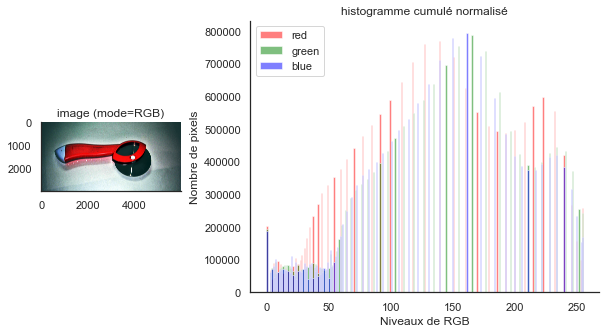

In [127]:
plot_image_histogram(img_equalize(img_contrast(IMG)))


### Filtrage de bruit

- (`PIL.Image.filter.GaussianBlur`)


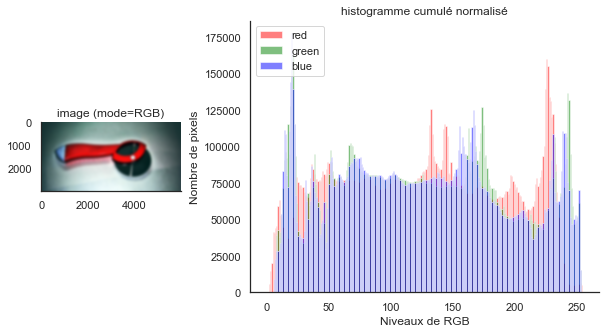

In [128]:
from PIL.ImageFilter import GaussianBlur


def img_gaussian_blur(img, radius=3):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return img.filter(GaussianBlur(radius))


plot_image_histogram(img_gaussian_blur(
    img_equalize(img_contrast(IMG)), radius=50))


### Filtrage de bruit (`PIL.Image.filter.MedianFilter`)

Ce filtre est non-lineaire qui donne les meilleur résultats mais prend plus de temps.


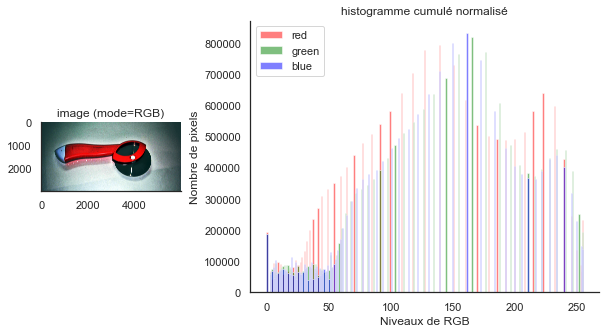

In [129]:
from PIL.ImageFilter import MedianFilter


def img_median_blur(img, size=3):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return img.filter(MedianFilter(size=size))


plot_image_histogram(img_median_blur(img_equalize(img_contrast(IMG))))


### Conversion en gris (réduction de dimensions de couleur)


In [130]:
from PIL import Image


def get_image_mode(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    mode = img.mode
    print(f'Image mode : {mode}')
    return mode


get_image_mode(IMG)


Image mode : RGB


'RGB'

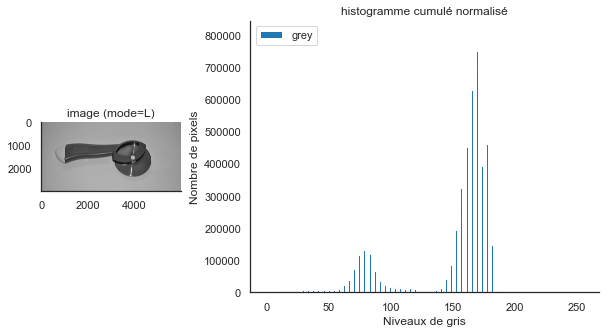

In [131]:
from PIL import Image
from PIL.ImageOps import grayscale


def img_to_gray(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return grayscale(img)


plot_image_histogram(img_to_gray(IMG))


### Reduction de taille (square, remplit)


In [132]:
from PIL import Image


def get_image_size(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    print(f'Largeur : {w} px, hauteur : {h} px')
    return w, h


get_image_size(IMG)


Largeur : 6000 px, hauteur : 2942 px


(6000, 2942)

Largeur : 6000 px, hauteur : 6000 px
(6000, 6000)


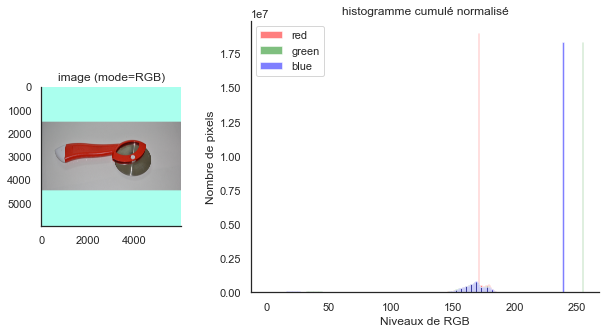

In [133]:
from PIL import Image


def img_squarify(img, bgcolor='white'):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    if w != h:
        max_hw = max(h, w)
        img_square = Image.new(img.mode, (max_hw, max_hw), bgcolor)
        img_square.paste(img, ((max_hw-w)//2, (max_hw-h)//2))
        img = img_square
    return img


sqr_img = img_squarify(IMG, bgcolor='#AAFFEE')
print(get_image_size(sqr_img))
plot_image_histogram(sqr_img)


Largeur : 224 px, hauteur : 109 px
(224, 109)


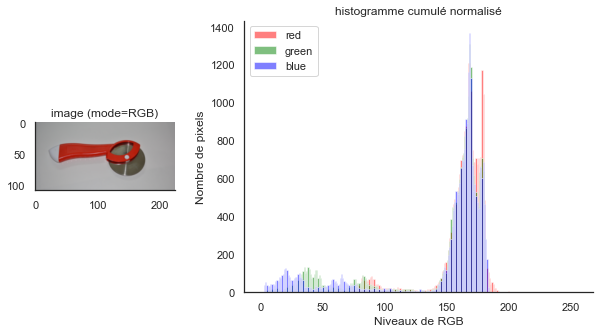

In [134]:
from PIL.Image import BICUBIC, BILINEAR, LANCZOS


def img_resize(img, sq_size=224, resample=BILINEAR):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    max_hw = max(h, w)
    scale = sq_size/max_hw
    new_w = int(w*scale)
    new_h = int(h*scale)
    return img.resize((new_w, new_h), resample=resample)


res_img = img_resize(IMG)
print(get_image_size(res_img))
plot_image_histogram(res_img)


## Pipeline de pretraitement d'un image


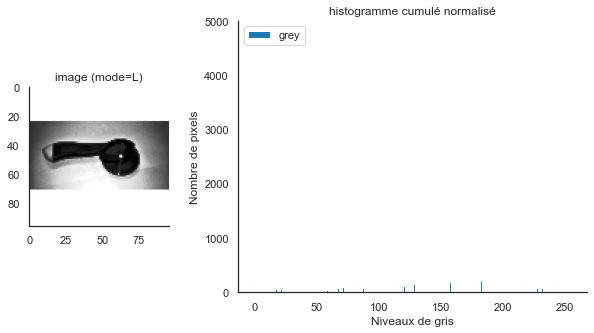

In [135]:
preprocess_params={
    'resize':{'sq_size':96},
     'gray':True,
     'squarify':True,
     'equalize':True,
     'contrast':True,
     'filter_gauss':False,
     'filter_median':False
}


def preprocess_img(img, params=preprocess_params):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    if params.get('gray'):
        img=img_to_gray(img)
    if params.get('resize'):
        img = img_resize(img, sq_size=params.get('resize').get('sq_size'))
    if params.get('squarify'):
        img = img_squarify(img)
    if params.get('filter_gauss'):
        img = img_gaussian_blur(img)
    if params.get('filter_median'):
        img = img_median_blur(img)  
    if params.get('equalize'):
        img = img_equalize(img)
    if params.get('contrast'):
        img=img_contrast(img)   

    return img

proc_img = preprocess_img(IMG)
plot_image_histogram(proc_img)
  

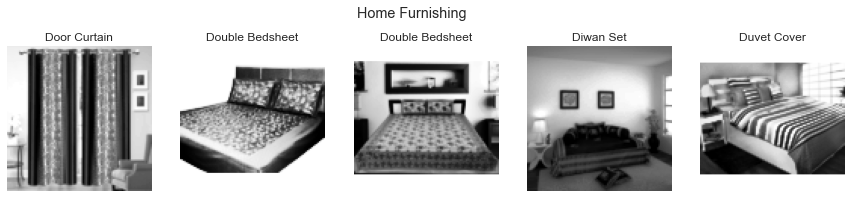

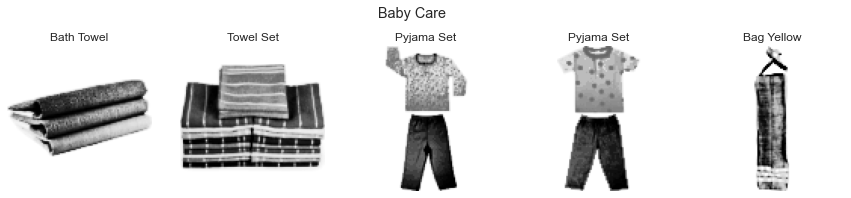

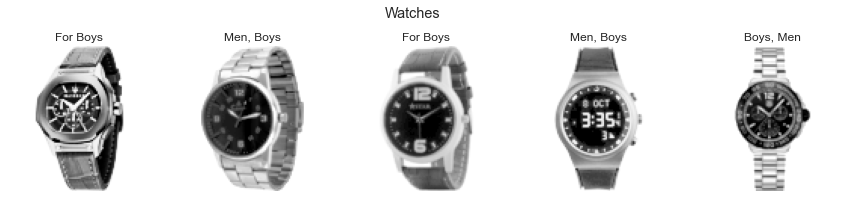

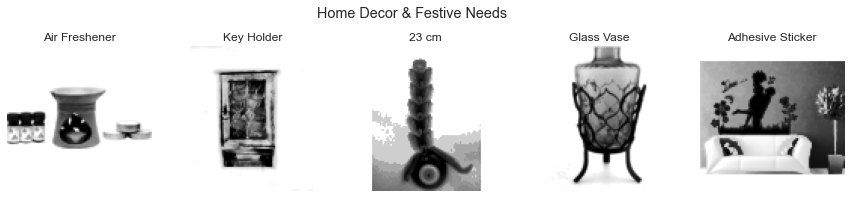

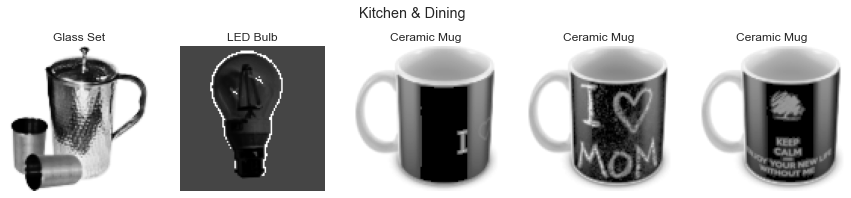

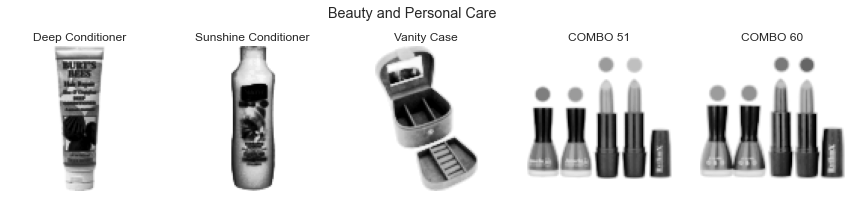

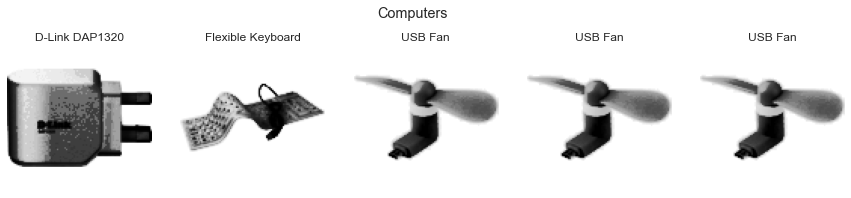

In [136]:
preview_images_by_category(
    df_data, preprocess_fct=preprocess_img, preprocess_params=preprocess_params)


## Enregistre les images prétraités

- Si le nombre d'images est grand ou la prétraitement prend du temps, on peut enregistrer les images prêt pour le feature extraction


## Nettoyage des variables globales


In [137]:
# del df_data


---


# 4. Fonctions communs pour modèles classification

- Lecture de données
- Scoring des modèles
- Visualisation de metriques de performance
- Visualisation des clusters


## 4.1 Lecture des données


In [138]:
data_T = pd.read_csv(f'{OUT_FOLDER}/data_cleaned.csv')
print(data_T.shape)


(1050, 20)


### 4.1.1 Variables pour comparer les catégories


In [139]:
from sklearn.preprocessing import LabelEncoder
cat_encoder = LabelEncoder()

# list des catégories de niveau 1
l_cat = sorted(list(set(data_T['categ_level_1'])))
l_cat_num = cat_encoder.fit_transform(l_cat)

# map de catégories
cat_map = dict(zip(l_cat_num, l_cat))
print("catégories : ", cat_map)
cat_encoder.inverse_transform(l_cat_num)


y_cat_num = cat_encoder.fit_transform(data_T['categ_level_1'])
y_cat_txt = data_T['categ_level_1'].copy()


catégories :  {0: 'Baby Care', 1: 'Beauty and Personal Care', 2: 'Computers', 3: 'Home Decor & Festive Needs', 4: 'Home Furnishing', 5: 'Kitchen & Dining', 6: 'Watches'}


In [140]:
cat_encoder.inverse_transform([1, 0, 5, 6])


array(['Beauty and Personal Care', 'Baby Care', 'Kitchen & Dining',
       'Watches'], dtype=object)

## 4.2 Modélisation et évaluation des modèles:

- **Prétraitement** des données (choix de description , lemmatization, stopwords,...) - voir ci-dessus. On utilise 'feature' pour choisir la colonne des données prétraitées.

- **Extraction de features** (par Bag-of-Words, TF-IDF, Word2Vec etc)

- **Réduction de dimensions** (par t-SNE, PCA, NMF, truncatedSVD...)

- **Classification (clustering) non-supervisée sur les dimensions réduits** (Gridsearch des hyperparamètres, sans ou avec choix de nombre de clusters)

  - par Kmeans (défaut)
  - par LDA (topic modelling)
  - par NMF (pas utilisé ici)

- **Evaluation de performance**:

  - distortion score (l'inertie ou somme d'erreurs carrés de chaque cluster)
  - score davies_bouldin (mésure de séparation des clusters)
  - score silhouette des clusters (+ visualisation des silhouettes de chaque cluster)
  - score stabilité des clusters (sur des sous-échantillons --> écart type)

- **Evaluation de correspondance avec les catégories définis**
  - ARI score
  - pourcentage des items mal classés
  - visualisation pour comparer les clusters sur les principaux dimensions réduits (TSNE ou PCA par exemple)
  - visualisation Sankey de correlations entre clusters


### 4.2.1 Scoring : performance d'un model

C'est compliqué a mettre en place un pipeline de preprocessing, feature extraction, dimension reduction, classification, scoring, car les librairies parfois retourne un matrice sparse, parfois pas.

Ci-dessous, ma procédure génerique pour score d'un model

- on varie parametre k pour evaluer le nombre de clusters pour un meilleur performance

On peut facilment ajouter un param_grid et faire un GridSearch sur tous les combinaisons des parametres :

```python
    # generate parameter grid for classifier
    param_sets = ParameterGrid(param_grid)

    for params in param_sets:
        # print(f'score model for params = {params}')
        # set model parameters (usually just n_clusters for classifier)
        model.set_params(**params)
        model.fit...
```


In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
import time
import scipy
from scipy.sparse import csr_matrix

param_grid = {'n_clusters': range(4, 12)}


def get_classname(estimator):
    return estimator.__class__.__name__


def score_model(df: pd.DataFrame,
                feature='sentence_bow_lem',
                labels_true=None,
                document_preprocessor=None,
                feature_extractor=TfidfVectorizer(
                    stop_words='english', max_df=0.95, min_df=3),
                dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000,
                                       init='random', learning_rate=200, random_state=RANDOM_SEED),
                kmin=7, kmax=7):
    """Executer un traitement de données, extraire les features, réduire les dimensions, et faire du clustering
    Returns : scores, labels et matrice de 'reduced dimensions'
    """

    # preprocess (normally done)
    if document_preprocessor is None:
        documents = df[feature]
    else:
        documents = document_preprocessor.fit_transform(df[feature])

    # extract features
    start_fit_extract = time.time()
    features = feature_extractor.fit_transform(documents)
    fit_time_extract = round(time.time()-start_fit_extract, 2)
    print(
        f'Extract_features ({get_classname(feature_extractor)}), fit time = {fit_time_extract} s')
    print(f'type(features) = {type(features)}')
    if isinstance(features, csr_matrix):
        print('converting features from sparse to dense array')
        # print(dir(features))
        features = features.toarray()

    # reduce dimensions
    start_fit_reduce = time.time()
    reduced_dimensions = dimension_reducer.fit_transform(features)
    fit_time_reduce = round(time.time()-start_fit_reduce, 2)
    print(
        f'Reduce dimensions ({get_classname(dimension_reducer)}), fit time = {fit_time_reduce} s')

    df_scores = pd.DataFrame({})

    for k in range(kmin, kmax+1):
        clusterer = KMeans(n_clusters=k)

        #
        start_fit_clf = time.time()
        clusterer.fit(reduced_dimensions)
        fit_time_clf = round(time.time()-start_fit_clf, 2)
        # print(f'Clusterer fit time = {fit_time_clf} s')

        labels_pred = clusterer.labels_
        cluster_sizes = (pd.Series(labels_pred).value_counts(
            normalize=True).values*100).astype(int)

        min_cluster_pct = pd.Series(
            labels_pred).value_counts(normalize=True).min()
        res = {'k': k,
               'min_cluster_pct': round(min_cluster_pct*100, 2),
               'distortion_score': round(getattr(clusterer, 'inertia_', 0), 0),
               'davies_bouldin': round(metrics.davies_bouldin_score(reduced_dimensions, labels_pred), 2),
               'calinski_harabasz': round(metrics.calinski_harabasz_score(reduced_dimensions, labels_pred), 2),
               'silhouette_score': round(metrics.silhouette_score(reduced_dimensions, labels_pred), 3),
               'fit_time_cluster': fit_time_clf
               }
        ARI = ''
        if not labels_true is None:
            res['ARI'] = round(metrics.adjusted_rand_score(
                labels_true, labels_pred), 3)
            ARI = f" ARI = {res['ARI']},"
        print(
            f"k={k}, fit: {fit_time_clf} s, silhouette= {res['silhouette_score']:.3},{ARI} cluster sizes = {cluster_sizes}")
        df_scores = df_scores.append(res, ignore_index=True)

    df_scores['feature_extraction'] = get_classname(feature_extractor)
    df_scores['dimension_reduction'] = get_classname(dimension_reducer)
    df_scores['classifier'] = get_classname(clusterer)
    df_scores['k'] = df_scores['k'].astype(int)

    if kmin == kmax:
        # utilise les dernier labels car ils sont aussi les premiers
        return df_scores, labels_pred, reduced_dimensions
    else:
        # fourni les labels du meilleur k (on peut plus inferer best_k = labels.nunique())
        best_score_idx = df_scores['silhouette_score'].idxmax()
        best_k = df_scores.loc[best_score_idx, 'k']
        clusterer = KMeans(n_clusters=best_k)
        clusterer.fit(reduced_dimensions)
        labels_pred = clusterer.labels_
        return df_scores, labels_pred, reduced_dimensions


# scores, labels, red_dim = score_model(data_T, 'sentence_bow_lem',
#                                       labels_true=data_T['categ_level_1'],
#                                       kmin=4, kmax=12)
# scores


## 4.3 Visualisations de metriques de performance

On s'inspire de yellowbrick KElbowVisualizer pour generaliser à d'autres metriques (stability par exemple)


In [142]:

def angle_between_vectors(v1, v2):
    """
    calculate angle between 2 vectors.
    use to find elbows
    """
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    ang = np.rad2deg(abs(ang1 - ang2) % (2 * np.pi))
    if ang > 180:
        ang = ang-180
    return ang


print([
    angle_between_vectors([1, 1], [0, 0]),
    angle_between_vectors([1, 1], [0, 1]),
    angle_between_vectors([1, 1], [-1, 0]),
    angle_between_vectors([1, 1], [-1, -1]),
])


[45.0, 45.0, 135.0, 180.0]


In [143]:

def find_elbow(df: pd.DataFrame, x_col='k', y_col='distortion_score'):
    """find sharpest difference in angle for [k, score]"""
    df = df.copy().reset_index()
    # standardise scale to maximise angles between points

    x_scale = df[x_col].max()-df[x_col].min()
    y_min = df[y_col].min()
    y_mult = (df[y_col].max()-y_min)/x_scale
    df['y_scaled'] = (df[y_col]-y_min)/y_mult

    # calculate angles between consecutive points
    n = len(df)
    for i in range(0, n-2):
        point1 = df.loc[i, [x_col, 'y_scaled']]
        point2 = df.loc[i+1, [x_col, 'y_scaled']]
        point3 = df.loc[i+2, [x_col, 'y_scaled']]
        vec1 = point2-point1
        vec2 = point3-point2
        df.loc[i+1, 'angle'] = angle_between_vectors(vec1, vec2)
    # elbow is at highest difference in angle (assume monotonic function)
    row = df['angle'].idxmax()
    x_elbow = df.loc[row, x_col]
    y_score = df.loc[row, y_col]
    return x_elbow, y_score


In [144]:

# k_best, distortion_score = find_elbow(scores, y_col='distortion_score')
# print(f'Best score for k = {k_best}')
# # check labels for best score have been returned
# print(pd.Series(labels).nunique())


### 4.3.1 Plot elbow visualiser


In [145]:

def plot_second_ax(df, x_col, y2_col, ax, color='grey'):
    """add a secondary y axis to a plot"""
    if y2_col in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df[x_col], df[y2_col], label=y2_col,
                 c=color, marker='o', linestyle='--', alpha=0.75)
        ax2.tick_params(axis='y', colors=color)
        ax2.set_ylabel(y2_col, color=color)


def plot_elbow(df, x_col, y_col, ax):
    """draw a vertical line at elbow on a plot"""
    elbow_k, elbow_score = find_elbow(df, x_col, y_col)
    elbow_label = f'elbow at ${x_col}={elbow_k}$'
    ax.axvline(elbow_k, c='k', linestyle="--", label=elbow_label)
    ax.legend(frameon=True)


def plot_vline(df, x_col, y_col, ax, line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at ${x_col}={line_x}$'
    ax.axvline(line_x, c='k', linestyle="--", label=line_label)
    ax.legend(frameon=True)


def plot_elbow_visualiser(df: pd.DataFrame, x_col='k', score_col='distortion_score',
                          show_elbow=False, time_col=None, ax1=None):
    """
    Generic ElbowVisualiser, capable of showing any metric, elbows, secondary axis...
    Allows subsequent manipulation of plots
    """
    colors = sns.color_palette("tab20").as_hex()
    if ax1 is None:
        _, ax1 = plt.subplots()
    # scores
    ax1.plot(df[x_col], df[score_col],
             marker="D", c=colors[0], linestyle="-")
    ax1.grid(False)
    ax1.tick_params(axis='y', colors=colors[0])
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(score_col, c=colors[0])
    # fit times
    if not time_col is None:
        plot_second_ax(df, x_col, y2_col=time_col, ax=ax1)
    if show_elbow:
        plot_elbow(df, x_col, score_col, ax1)


# Test visualiser
# plot_elbow_visualiser(scores, score_col='distortion_score', show_elbow=True)
# plt.suptitle(f'Kmeans Distortion Score')
# to_png()


### 4.3.2 Plot summary metrics

- visualiser plusieurs metriques com subplots


In [146]:
# print(sorted(list(scores.columns)))


In [147]:

def plot_metrics(df_scores, x_col='k'):
    """
    Plot each clustering metric in df_scores in a subplot
    Plots to show depend on metrics added to df_scores
    Parameters
    ----------
    df_scores   Scores for all permutations of a param_grid (previously calculated)
    x_col       Choice of parameter to compare -by default k, but can show any hyperparameter
    """
    if 'clf' in df_scores.columns and 'preprocessor' in df_scores.columns:
        print(
            f"plotting metrics (clf: {df_scores['clf'][0]}, preprocessor: {df_scores['preprocessor'][0]})")

    METRICS = ['distortion_score', 'calinski_harabasz',
               'davies_bouldin', 'silhouette_score', 'stability_score']
    metrics = cols_in_df(df_scores, METRICS)
    n_plots = len(metrics)
    n_cols = min(n_plots, 2)
    # n_rows = int(ceil(n_plots/n_cols))
    n_rows = n_plots // n_cols + (n_plots % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*5, n_rows*3))
    for n, metric in enumerate(metrics):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        if metric == 'distortion_score':
            plot_elbow_visualiser(
                df_scores, x_col, metric, ax1=ax, time_col='fit time (s)', show_elbow=True)
            plt.title(metric)
        if metric == 'calinski_harabasz':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(f'{metric} score (max={df_scores[metric].max():.0f})')
        if metric == 'davies_bouldin':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='min')
            plt.title(f'{metric} score (min={df_scores[metric].min():.2f})')
        if metric == 'silhouette_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'silhouette_score_std' in df_scores.columns:
                if 'silhouette_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['silhouette_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='silhouette_score',
                             yerr='silhouette_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='silhouette_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)
        if metric == 'stability_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'stability_score_std' in df_scores.columns:
                if 'stability_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['stability_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='stability_score',
                             yerr='stability_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='stability_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.suptitle(
        f"Plot metrics (feature extraction : {df_scores['feature_extraction'][0]};   dimension reduction {df_scores['dimension_reduction'][0]})")


# test
# plot_metrics(scores)
# to_png()


## 4.4 Visualisation des clusters sur les 'reduced_dimensions'


### 4.4.1 Calcul de meilleur correspondance entre categorie et cluster label

Les cluster labels attribué par des modélisations (ex: kmeans) sont aléatoires, que fait que des comparaisons entre la catégorie atribuée et les libellés sont difficil a comparer : ils n'ont pas les même couleurs

On essaie de faire correspondre les cluster labels dans la même ordre que categ_true,
pour faciliter : - la matrice de confusion entre categorie et cluster - la comparaison des clusters sur plots tsne/pca (couleurs plus proche) - les diagrammes Sankey pour montre les rélations

- https://sparse-plex.readthedocs.io/en/latest/book/clustering/comparing_clusterings.html
- https://python.plainenglish.io/hungarian-algorithm-introduction-python-implementation-93e7c0890e15
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

Comme alternative à KMeans (algorithme publié octobre 2021):

- https://www.researchgate.net/publication/353696146_The_utility_of_clusters_and_a_Hungarian_clustering_algorithm


In [148]:
from scipy.optimize import linear_sum_assignment


def squarify_df(df: pd.DataFrame, val=0):
    rows, cols = df.shape
    if rows > cols:
        # append columns to end of dataframe
        pad_cols = rows-cols
        pad_df = pd.DataFrame(
            np.zeros((rows, pad_cols), dtype=int), index=df.index)
        pad_df.columns = [f'pad_{i}'for i in range(pad_cols)]
        df = df.join(pad_df)
    elif cols > rows:
        # append rows to end of dataframe
        pad_rows = cols-rows
        pad_df = pd.DataFrame(data=np.zeros((cols-rows, cols), dtype=int),
                              columns=range(cols))
        pad_df.index = [f'pad_{i}'for i in range(pad_rows)]
        df = df.append(pad_df)
    return df


df_test_rows = pd.DataFrame([[1, 0, 6], [0, 3, 3]])
df_test_cols = df_test_rows.T
print(df_test_rows.shape)
print(squarify_df(df_test_rows))
print(squarify_df(df_test_cols))


(2, 3)
       0  1  2
0      1  0  6
1      0  3  3
pad_0  0  0  0
   0  1  pad_0
0  1  0      0
1  0  3      0
2  6  3      0


In [149]:
def conf_matrix_labels(categ_true, clust_labels, normalize=False):
    """
    Calcul de meilleur correspondance entre true_categorie et predicted categorie

    Les cluster labels attribué par kmeans sont aléatoires. 
    On essaie de mettre les cluster labels dans la même ordre que categ_true, 
    pour faciliter :
        - la matrice de confusion entre categorie et cluster
        - la comparaison des clusters sur plots tsne/pca (couleurs plus proche)
        - les diagrammes Sankey pour montre les rélations 
    """

    # créer le crosstab entre categorie et cluster label
    df_matr: pd.DataFrame = pd.crosstab(categ_true, clust_labels,
                                        normalize=normalize)

    # Si besoin, créer un matrice carré pour pouvoir applique l'algorithme
    n_categ = df_matr.shape[0]
    n_labels = df_matr.shape[1]

    square_matr = squarify_df(df_matr).fillna(0)

    # trouve ordre de colonnes et lignes pour maximiser valeurs dans le diagonale
    rows, cols = linear_sum_assignment(square_matr.values, maximize=True)

    if len(rows) > n_categ:
        rows = [idx for idx in rows if idx < n_categ]
    if len(cols) > n_labels:
        cols = [idx for idx in cols if idx < n_labels]
    # print(f'len(rows) : {len(rows)}')
    # print(f'len(cols) : {len(cols)}')
    df_opt = df_matr.iloc[:, cols]

    new_cols = [str(col) for col in df_opt.index]
    cluster_labelmap = dict(zip(list(df_opt.columns), new_cols))

    if normalize == False:
        df_opt = df_opt.round(0).astype(int)

    return df_opt, cluster_labelmap


# str_labels = pd.Series(labels).map(lambda x: f'cluster_{x}')
# conf_matrix_labels(categ_true=y_cat_txt,
#                    clust_labels=pd.Series(labels, dtype=str))


### 4.4.2 Clustering KMeans via TSNE, et calcul de metric ARI

Un fois les scores sont calculés, les procédures ci-dessous permet de visualiser


In [150]:
from sklearn import manifold
import time
from numpy import ndarray


def reducer_tsne(features: pd.Series) -> ndarray:
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=RANDOM_SEED)
    X_tsne = tsne.fit_transform(features)
    time2 = np.round(time.time() - time1, 0)
    print(f'reducer t-SNE, shape ={X_tsne.shape} time : {time2}')
    return X_tsne


In [ ]:
from sklearn import cluster, metrics
import time


def calc_ARI(labels_pred, labels_true=y_cat_num):
    """Calcul l'Adjusted Rand Index score"""
    return np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 4)


def calc_tsne_cluster(features, categories_=l_cat, y_cat_num_=y_cat_num, k=None):
    """
    Calcul Tsne, détermination des clusters et calcul ARI 
    entre vrais catégorie et n° de clusters
    """
    X_tsne = reducer_tsne(features)

    if k is None or not k > 0:
        k = len(categories_)

    time1 = time.time()
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=k, n_init=100,
                         random_state=RANDOM_SEED)
    cls.fit(X_tsne)
    time2 = np.round(time.time() - time1, 0)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num_, cls.labels_), 4)

    print("ARI : ", ARI, "time : ", time2)
    # ajout cls.cluster_centers_ ?
    return ARI, X_tsne, cls.labels_


### 4.2.2 Visualisation des clusters sur les dimensions réduits


In [ ]:

#
def plot_clusters_sur_2D(X_tsne_, y_cat_num_, labels_, ARI_, l_cat_=l_cat,
                         bbox_left=-0.05, loc=1,
                         palette='bright',
                         titre1='Représentation des produits par catégories réelles',
                         titre2='Représentation des produits par clusters'):
    """
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    """
    if ARI_ is None:
        ARI_ = calc_ARI(y_cat_num_, labels_)
    df_opt, label_map = conf_matrix_labels(y_cat_num_, labels_)

    # s_labels=pd.Series(labels_).map(label_map)
    s_labels = pd.Series(labels_)

    # mettre l'ordre des clusters dans la même ordre que les y_cat
    labels_hue_order = list(df_opt.columns)
    n_labels = len(labels_hue_order)

    categ_hue_order = sorted(list(pd.Series(y_cat_num_).unique()))
    n_categ = len(categ_hue_order)

    n_max = max(n_labels, n_categ)
    colors = sns.color_palette(palette, n_colors=n_max)
    # print (colors)
    labels_palette = colors[:n_labels]
    categ_palette = colors[:n_categ]
    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_subplot(121)
    scatter1 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax1,
                               hue=y_cat_num_, hue_order=categ_hue_order, palette=categ_palette)
    ax1.legend(title="Categorie", bbox_to_anchor=(bbox_left, 0.5), loc=loc)
    plt.title(titre1)

    ax2 = fig.add_subplot(122)
    scatter2 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax2,
                               hue=s_labels, hue_order=labels_hue_order, palette=labels_palette)
    ax2.legend(loc="best", title="Clusters")
    plt.title(titre2)
    print("ARI : ", ARI_)
    return fig


### Calcul des clusters et affichage


In [ ]:
# scores1, labels1, X_tsne1 = score_model(data_T, labels_true=y_cat_txt,
#                                        feature_extractor=CountVectorizer(
#                                            stop_words='english', ngram_range=(1, 1), max_df=0.95, min_df=3),
#                                        dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000,
#                                        init='random', learning_rate='auto'),
#                                        kmin=4, kmax=12)
# plot_metrics(scores1)


# 9. Enregistrement des résultats

Enregistre données avec les libellés produit par chaque modèle


In [ ]:
# data_T.to_csv(f'{OUT_FOLDER}/data_image_labelled.csv')
